# Head Estimation, Pose Conversion & Visualization

## 1. Load and Process Keypoints JSON

In [1]:
indices = [0, 1, 2, 3, 4, 5, 6, 11, 12]

def access_elements(data, indices):
    return [data[i] for i in indices]

In [236]:
import json

# Load person_keypoints_train2017.json and extract poses which have all of their body keypoints
'''
"keypoints": [
                        "nose",
                        "left_eye",
                        "right_eye",
                        "left_ear",
                        "right_ear",
                        
                        "left_shoulder",
                        "right_shoulder",
                        "left_elbow",
                        "right_elbow",
                        "left_wrist",
                        "right_wrist",

                        "left_hip",
                        "right_hip",
                        "left_knee",
                        "right_knee",
                        "left_ankle",
                        "right_ankle"
                    ],
'''

def extract_poses(file_path, scale=2):
    with open(file_path, 'r') as f:
        data = json.load(f)

    poses_list = []

    for annotation in data['annotations']:
        visibility = access_elements(annotation['keypoints'][2::3], indices)

        if 0 not in visibility:
            keypoints_x = access_elements(annotation['keypoints'][0::3], indices)
            keypoints_y = access_elements(annotation['keypoints'][1::3], indices)

            max_x = max(keypoints_x)
            min_x = min(keypoints_x)
            max_y = max(keypoints_y)
            min_y = min(keypoints_y)

            height = max_y - min_y
            width = max_x - min_x

            if height > width:
                keypoints_x = [((x - min_x) / height - 0.5) * scale for x in keypoints_x]
                keypoints_y = [((y - min_y) / height - 0.5) * scale for y in keypoints_y]
            else:
                keypoints_x = [((x - min_x) / width - 0.5) * scale for x in keypoints_x]
                keypoints_y = [((y - min_y) / width - 0.5) * scale for y in keypoints_y]

            poses_list.append((keypoints_x[5:] + keypoints_y[5:], keypoints_x[:5] + keypoints_y[:5]))

    return poses_list

# File path to the JSON file
file_path = 'person_keypoints_train2017.json'

# Extract keypoints
extracted_poses = extract_poses(file_path)

# Print the result
result_len = len(extracted_poses)
print(extracted_poses[:5])
print(f"Number of extracted poses: {result_len}")

split = 0.8

# Save the result
with open("train.json", "w") as train:
    json.dump(extracted_poses[:int(result_len * split)], train)

with open("test.json", "w") as test:
    json.dump(extracted_poses[int(result_len * split):], test)

[([0.25, -1.0, 0.1607142857142858, -0.7053571428571428, -0.3303571428571429, -0.2946428571428571, 0.9732142857142858, 1.0], [-0.3125, -0.1875, -0.4732142857142857, -0.0535714285714286, -0.6517857142857143, -0.9107142857142857, -1.0, -1.0, -0.8571428571428572, -0.8303571428571428]), ([0.2142857142857142, -1.0, 0.2142857142857142, -0.9285714285714286, -0.3214285714285714, -0.2857142857142857, 0.9642857142857142, 1.0], [-0.4285714285714286, -0.3571428571428571, -0.5357142857142857, -0.2142857142857143, -0.7142857142857143, -0.8928571428571429, -1.0, -1.0, -0.9642857142857143, -0.9285714285714286]), ([-0.30149253731343284, -1.0, -0.31343283582089554, -0.9044776119402985, -0.33134328358208953, -0.4208955223880597, 0.9462686567164178, 1.0], [-0.33134328358208953, -0.28955223880597014, -0.4447761194029851, -0.24776119402985075, -0.6238805970149254, -0.8985074626865672, -0.9582089552238806, -1.0, -0.8865671641791044, -0.9402985074626866]), ([-0.27586206896551724, -1.0, -0.27586206896551724, -0

## 2. Load Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset

print(f"MPS Support: {torch.backends.mps.is_built()}")
print(f"MPS Availability: {torch.backends.mps.is_available()}")

MPS Support: True
MPS Availability: True


In [3]:
device = None

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f'Device: {device}')

Device: mps


## 3. Dataloader and Model Definition

### Dataloader

In [4]:
split = 0.8

class TrainDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        train_path = data_dir + "/train.json"

        with open(train_path, 'r') as f:
            data = json.load(f)
            data_len = len(data)
            self.data = data[:int(data_len * split)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return torch.tensor(self.data[index][0]), torch.tensor(self.data[index][1])


class ValDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        train_path = data_dir + "/train.json"

        with open(train_path, 'r') as f:
            data = json.load(f)
            data_len = len(data)
            self.data = data[int(data_len * split):]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return torch.tensor(self.data[index][0]), torch.tensor(self.data[index][1])
    
    
class TestDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        test_path = data_dir + "/test.json"

        with open(test_path, 'r') as f:
            self.data = json.load(f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return torch.tensor(self.data[index][0]), torch.tensor(self.data[index][1])

In [5]:
import json

train_dataset = TrainDataset(data_dir='.')
val_dataset = ValDataset(data_dir='.')
test_dataset = TestDataset(data_dir='.')

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

11939
2985
3731


### Model

In [6]:
# Define the model
class HeadEstimator(nn.Module):
    def __init__(self):
        super(HeadEstimator, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.2)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(512)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight.data)
                nn.init.zeros_(m.bias.data)
                

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        out = self.fc4(x)

        return out

### Train and Val Function

In [13]:
def train_model(trainloader, model, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0

    for batch, (inputs, targets) in tqdm(enumerate(trainloader), total=len(trainloader)):

        inputs = inputs.to(device)
        targets = targets.to(device)
        #criterion = criterion.to(device)

        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds, targets)

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.cpu().item()

    return total_loss / (batch + 1)

In [14]:
def val_model(valloader, model, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch, (inputs, targets) in tqdm(enumerate(valloader), total = len(valloader)):

            inputs = inputs.to(device)
            targets = targets.to(device)
            #criterion = criterion.to(device)

            preds = model(inputs)
            loss = criterion(preds, targets)
            
            total_loss += loss.cpu().item()

    return total_loss/(batch+1)

## 4. Training Model

In [245]:
batch_size = 64
learning_rate = 1e-5
epochs = 50

trainLoader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valLoader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

model = HeadEstimator()
model = model.to(device)

def loss(preds, targets):
    mse = torch.mean((preds - targets) ** 2)

    eye_dist = torch.mean((preds[:, 1:3] - targets[:, 1:3]) ** 2 
                            + (preds[:, 6:8] - targets[:, 6:8]) ** 2)
    
    ear_dist = torch.mean((preds[:, 3:5] - targets[:, 3:5]) ** 2 
                            + (preds[:, 8:10] - targets[:, 8:10]) ** 2)

    return mse + eye_dist + ear_dist

#criterion = nn.MSELoss()
criterion = loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=2000, gamma=0.5)

history = {'train_loss':[], 'val_loss':[]}

print(model)

HeadEstimator(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [246]:
print("Training...")

for epoch in range(epochs):
    train_loss = train_model(trainLoader, model, criterion, optimizer, scheduler, device)
    val_loss = val_model(valLoader, model, criterion, device)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    if (epoch+1) % 5 == 0 or epoch == epochs-1:
        print("Saving checkpoint...")
        torch.save(model.state_dict(), f'./model.pth')

print('Finished Training')

Training...


100%|██████████| 47/47 [00:00<00:00, 64.78it/s] 


Epoch 1/50, Train Loss: 4.1816, Val Loss: 1.8128


100%|██████████| 47/47 [00:00<00:00, 151.87it/s]


Epoch 2/50, Train Loss: 2.7992, Val Loss: 1.2166


100%|██████████| 47/47 [00:00<00:00, 152.00it/s]


Epoch 3/50, Train Loss: 2.2607, Val Loss: 0.7632


100%|██████████| 47/47 [00:00<00:00, 150.75it/s]


Epoch 4/50, Train Loss: 1.9455, Val Loss: 0.6006


100%|██████████| 47/47 [00:00<00:00, 152.53it/s]


Epoch 5/50, Train Loss: 1.7514, Val Loss: 0.4966
Saving checkpoint...


100%|██████████| 47/47 [00:00<00:00, 152.57it/s]


Epoch 6/50, Train Loss: 1.6163, Val Loss: 0.4141


100%|██████████| 47/47 [00:00<00:00, 153.10it/s]


Epoch 7/50, Train Loss: 1.4884, Val Loss: 0.3860


100%|██████████| 47/47 [00:00<00:00, 148.22it/s]


Epoch 8/50, Train Loss: 1.4152, Val Loss: 0.3517


100%|██████████| 47/47 [00:00<00:00, 154.57it/s]


Epoch 9/50, Train Loss: 1.3489, Val Loss: 0.3225


100%|██████████| 47/47 [00:00<00:00, 153.16it/s]


Epoch 10/50, Train Loss: 1.2658, Val Loss: 0.2893
Saving checkpoint...


100%|██████████| 47/47 [00:00<00:00, 151.76it/s]


Epoch 11/50, Train Loss: 1.2180, Val Loss: 0.2901


100%|██████████| 47/47 [00:00<00:00, 152.61it/s]


Epoch 12/50, Train Loss: 1.1923, Val Loss: 0.2810


100%|██████████| 47/47 [00:00<00:00, 154.26it/s]


Epoch 13/50, Train Loss: 1.1426, Val Loss: 0.2358


100%|██████████| 47/47 [00:00<00:00, 155.15it/s]


Epoch 14/50, Train Loss: 1.1308, Val Loss: 0.2707


100%|██████████| 47/47 [00:00<00:00, 157.18it/s]


Epoch 15/50, Train Loss: 1.0985, Val Loss: 0.2408
Saving checkpoint...


100%|██████████| 47/47 [00:00<00:00, 154.04it/s]


Epoch 16/50, Train Loss: 1.0905, Val Loss: 0.2389


100%|██████████| 47/47 [00:00<00:00, 157.57it/s]


Epoch 17/50, Train Loss: 1.0537, Val Loss: 0.2204


100%|██████████| 47/47 [00:00<00:00, 155.88it/s]


Epoch 18/50, Train Loss: 1.0330, Val Loss: 0.2313


100%|██████████| 47/47 [00:00<00:00, 155.67it/s]


Epoch 19/50, Train Loss: 1.0071, Val Loss: 0.2152


100%|██████████| 47/47 [00:00<00:00, 155.37it/s]


Epoch 20/50, Train Loss: 0.9876, Val Loss: 0.2234
Saving checkpoint...


100%|██████████| 47/47 [00:00<00:00, 141.36it/s]


Epoch 21/50, Train Loss: 0.9519, Val Loss: 0.2325


100%|██████████| 47/47 [00:00<00:00, 129.23it/s]


Epoch 22/50, Train Loss: 0.9410, Val Loss: 0.1986


100%|██████████| 47/47 [00:00<00:00, 159.39it/s]


Epoch 23/50, Train Loss: 0.9459, Val Loss: 0.2040


100%|██████████| 47/47 [00:00<00:00, 157.26it/s]


Epoch 24/50, Train Loss: 0.9151, Val Loss: 0.1944


100%|██████████| 47/47 [00:00<00:00, 157.39it/s]


Epoch 25/50, Train Loss: 0.9144, Val Loss: 0.1974
Saving checkpoint...


100%|██████████| 47/47 [00:00<00:00, 155.70it/s]


Epoch 26/50, Train Loss: 0.8990, Val Loss: 0.1893


100%|██████████| 47/47 [00:00<00:00, 157.79it/s]


Epoch 27/50, Train Loss: 0.8785, Val Loss: 0.1978


100%|██████████| 47/47 [00:00<00:00, 156.32it/s]


Epoch 28/50, Train Loss: 0.8770, Val Loss: 0.1748


100%|██████████| 47/47 [00:00<00:00, 157.29it/s]


Epoch 29/50, Train Loss: 0.8798, Val Loss: 0.1865


100%|██████████| 47/47 [00:00<00:00, 157.03it/s]


Epoch 30/50, Train Loss: 0.8690, Val Loss: 0.1997
Saving checkpoint...


100%|██████████| 47/47 [00:00<00:00, 156.18it/s]


Epoch 31/50, Train Loss: 0.8432, Val Loss: 0.1837


100%|██████████| 47/47 [00:00<00:00, 156.26it/s]


Epoch 32/50, Train Loss: 0.8451, Val Loss: 0.1638


100%|██████████| 47/47 [00:00<00:00, 157.86it/s]


Epoch 33/50, Train Loss: 0.8304, Val Loss: 0.1796


100%|██████████| 47/47 [00:00<00:00, 157.19it/s]


Epoch 34/50, Train Loss: 0.8373, Val Loss: 0.1641


100%|██████████| 47/47 [00:00<00:00, 156.70it/s]


Epoch 35/50, Train Loss: 0.8348, Val Loss: 0.1758
Saving checkpoint...


100%|██████████| 47/47 [00:00<00:00, 156.36it/s]


Epoch 36/50, Train Loss: 0.8243, Val Loss: 0.1568


100%|██████████| 47/47 [00:00<00:00, 156.45it/s]


Epoch 37/50, Train Loss: 0.8204, Val Loss: 0.1639


100%|██████████| 47/47 [00:00<00:00, 156.02it/s]


Epoch 38/50, Train Loss: 0.8048, Val Loss: 0.1737


100%|██████████| 47/47 [00:00<00:00, 156.64it/s]


Epoch 39/50, Train Loss: 0.8066, Val Loss: 0.1801


100%|██████████| 47/47 [00:00<00:00, 156.07it/s]


Epoch 40/50, Train Loss: 0.8131, Val Loss: 0.1858
Saving checkpoint...


100%|██████████| 47/47 [00:00<00:00, 124.64it/s]


Epoch 41/50, Train Loss: 0.8026, Val Loss: 0.1761


100%|██████████| 47/47 [00:00<00:00, 153.33it/s]


Epoch 42/50, Train Loss: 0.8071, Val Loss: 0.1638


100%|██████████| 47/47 [00:00<00:00, 152.30it/s]


Epoch 43/50, Train Loss: 0.7970, Val Loss: 0.1664


100%|██████████| 47/47 [00:00<00:00, 155.38it/s]


Epoch 44/50, Train Loss: 0.7872, Val Loss: 0.1765


100%|██████████| 47/47 [00:00<00:00, 155.42it/s]


Epoch 45/50, Train Loss: 0.7948, Val Loss: 0.1591
Saving checkpoint...


100%|██████████| 47/47 [00:00<00:00, 157.04it/s]


Epoch 46/50, Train Loss: 0.7757, Val Loss: 0.1583


100%|██████████| 47/47 [00:00<00:00, 158.13it/s]


Epoch 47/50, Train Loss: 0.7944, Val Loss: 0.1766


100%|██████████| 47/47 [00:00<00:00, 145.51it/s]


Epoch 48/50, Train Loss: 0.7794, Val Loss: 0.1846


100%|██████████| 47/47 [00:00<00:00, 155.43it/s]


Epoch 49/50, Train Loss: 0.7854, Val Loss: 0.1687


100%|██████████| 47/47 [00:00<00:00, 156.13it/s]


Epoch 50/50, Train Loss: 0.7790, Val Loss: 0.1595
Saving checkpoint...
Finished Training


<function matplotlib.pyplot.show(close=None, block=None)>

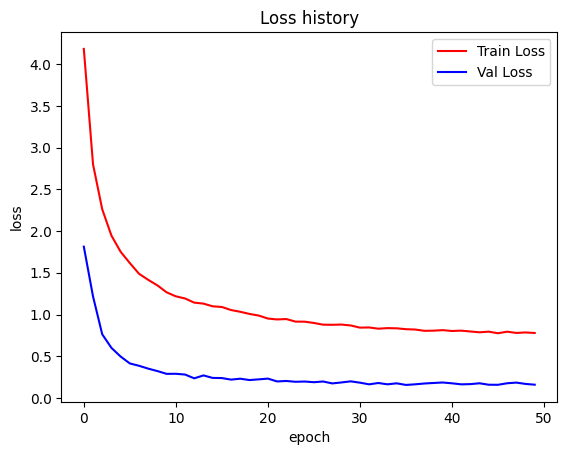

In [249]:
plt.plot(range(epochs), history['train_loss'], label='Train Loss', color='red')
plt.plot(range(epochs), history['val_loss'], label='Val Loss', color='blue')

plt.title('Loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.show

## 5. Test Model

In [250]:
def test_model(testloader, model, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch, (inputs, targets) in tqdm(enumerate(testloader), total = len(testloader)):

            inputs = inputs.to(device)
            targets = targets.to(device)

            preds = model(inputs)
            loss = criterion(preds, targets)
            
            total_loss += loss.cpu().item()

    return total_loss/(batch+1)

In [251]:
testLoader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

print("Testing...")
test_loss = test_model(testLoader, model, criterion, device)

print(f"Test Loss: {test_loss:.4f}")

Testing...


100%|██████████| 59/59 [00:00<00:00, 144.61it/s]

Test Loss: 0.1405


## 6. Inference and Visualization Functions

In [7]:
def inference(model, device, x):
    model.eval()
    x = x.to(device)

    with torch.no_grad():
        pred = model(x)
        
    return pred[:10]

In [8]:
def normalize_pose(pose, scale=2):
    
    keypoints_x = [point[0] for point in pose]
    keypoints_y = [point[1] for point in pose]

    min_x = min(keypoints_x)
    max_x = max(keypoints_x)
    min_y = min(keypoints_y)
    max_y = max(keypoints_y)
    
    height = max_y - min_y
    width = max_x - min_x

    if height > width:
        keypoints_x = [((x - min_x) / height - 0.5) * scale for x in keypoints_x]
        keypoints_y = [((y - min_y) / height - 0.5) * scale for y in keypoints_y]
        original_scale = height
    else:
        keypoints_x = [((x - min_x) / width - 0.5) * scale for x in keypoints_x]
        keypoints_y = [((y - min_y) / width - 0.5) * scale for y in keypoints_y]
        original_scale = width

    
    print('keypoints_x = "', keypoints_x, '"')
    print('keypoints_y = "', keypoints_y, '"\n')

    pose = [(x, y) for x, y in zip(keypoints_x, keypoints_y)]

    return pose, min_x, min_y, original_scale, original_scale

def denormalize_pose(pose, min_x, min_y, width, height, scale=2):
    pose = [((x / scale + 0.5) * width + min_x, (y / scale + 0.5) * height + min_y) for (x, y) in pose]

    return pose

def resize_pose(pose, resize_width=200, resize_height=200, padding=10, scale=2):
    pose, _, _, _, _ = normalize_pose(pose, scale)
    pose = [((x / scale + 0.5) * resize_width + padding, (y / scale + 0.5) * resize_height + padding) for (x, y) in pose]

    return pose

In [9]:
'''
coco (original):
0 : nose
1 2 : eyes
3 4 : ears
5 7 9 : left arm
6 8 10: right arm
11 13 15: left leg
12 14 16: right leg

mpii (ours):
13 14 15 : left arm
12 11 10 : right arm
3 4 5 : left leg
2 1 0 : right leg
7 : neck
9 8 : head

coco (ours):
0 : nose
1 : neck
2 3 4 : right arm
5 6 7 : left arm
8 9 10 : right leg
11 12 13 : left leg
14 15 : eyes
16 17 : ears
'''

def convert_pose(model, device, pose):
    # re-order keypoints to match neural network input
    reordered_pose = [pose[13], pose[12], pose[14], pose[11], pose[15], pose[10], pose[3], pose[2], pose[4], pose[1], pose[5], pose[0]]

    upper_body = access_elements(reordered_pose, [0, 1, 6, 7]) + [((pose[8][0] + pose[9][0]*2)/3, (pose[8][1] + pose[9][1]*2)/3)]
    upper_body, min_x, min_y, width, height = normalize_pose(upper_body)

    input_x = [point[0] for point in upper_body[:4]]
    input_y = [point[1] for point in upper_body[:4]]

    input_pose = torch.tensor([input_x + input_y])

    # head inference
    head = inference(model, device, input_pose)[0].cpu().tolist()
    head_points = [(x, y) for x, y in zip(head[:5], head[5:])]

    # denormalize head keypoints
    head_points = denormalize_pose(head_points, min_x, min_y, width, height)

    # insert head keypoints to the pose
    reordered_pose = [head_points[0], pose[7], pose[12], pose[11], pose[10], pose[13], pose[14], pose[15], pose[2], pose[1], pose[0], pose[3], pose[4], pose[5],
                      head_points[1], head_points[2], head_points[3], head_points[4]]

    return reordered_pose

In [10]:
import cv2
import matplotlib.pyplot as plt


mpii_link_pairs = [[0, 1], [1, 2], [2, 6], 
              [3, 6], [3, 4], [4, 5], 
              [6, 7], [7,12], [11, 12], 
              [10, 11], [7, 13], [13, 14],
              [14, 15],[7, 8],[8, 9]]

mpii_link_color = [(0, 0, 255), (0, 0, 255), (0, 0, 255),
              (0, 255, 0), (0, 255, 0), (0, 255, 0),
              (0, 255, 255), (0, 0, 255), (0, 0, 255),
              (0, 0, 255), (0, 255, 0), (0, 255, 0),
              (0, 255, 0), (0, 255, 255), (0, 255, 255)]

mpii_point_color = [(255,0,0),(0,255,0),(0,0,255), 
               (128,0,0), (0,128,0), (0,0,128),
               (255, 255, 0),(0,255,255),(255, 0, 255),
               (128,128,0),(0, 128, 128),(128,0,128),
               (128,255,0),(128,128,128),(255,128,0),
               (255,0,128),(255,255,255)]


coco_link_pairs = [[0, 1], [1, 2], [2, 3], 
              [3, 4], [1, 5], [5, 6], 
              [6, 7], [1, 8], [8, 9], 
              [9, 10], [1, 11], [11, 12],
              [12, 13],[0, 14],[14, 16], [0, 15], [15, 17]]

coco_link_color = [(0, 0, 255), (0, 0, 255), (0, 0, 255),
              (0, 255, 0), (0, 255, 0), (0, 255, 0),
              (0, 255, 255), (0, 0, 255), (0, 0, 255),
              (0, 0, 255), (0, 255, 0), (0, 255, 0),
              (0, 255, 0), (0, 255, 255), (0, 255, 255), (128, 128, 0), (128, 0, 128)]

coco_point_color = [(255,0,0),(0,255,0),(0,0,255), 
               (128,0,0), (0,128,0), (0,0,128),
               (255, 255, 0),(0,255,255),(255, 0, 255),
               (128,128,0),(0, 128, 128),(128,0,128),
               (128,255,0),(128,128,128),(255,128,0),
               (255,0,128),(255,255,255), (128, 128, 0), (128, 0, 128)]

'''
mpii (ours):
2 1 0 : right leg
3 4 5 : left leg
12 11 10 : right arm
13 14 15 : left arm
7 : neck
9 8 : head

coco (ours):
0 : nose
1 : neck
2 3 4 : right arm
5 6 7 : left arm
8 9 10 : right leg
11 12 13 : left leg
14 15 : eyes
16 17 : ears
'''

def vis_pose(image_path, pose, link_pairs, link_color, point_color):
    image = cv2.imread(image_path)

    pose = [(int(x), int(y)) for (x, y) in pose]

    for idx, pair in enumerate(link_pairs):
        if pose[pair[0]] != (0, 0) and pose[pair[1]] != (0, 0):
            cv2.line(image, pose[pair[0]], pose[pair[1]], link_color[idx], 2)

    for idx, point in enumerate(pose):
        if point != (0, 0):
            cv2.putText(image, str(idx), point, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
            cv2.circle(image, point, 5, point_color[idx], thickness=-1)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


def vis_pose_mpii(image_path, pose):
    vis_pose(image_path, pose, mpii_link_pairs, mpii_link_color, mpii_point_color)


def vis_pose_coco(image_path, pose):
    vis_pose(image_path, pose, coco_link_pairs, coco_link_color, coco_point_color)

In [11]:
import os

def vis_data(model, device, data, image_dir_path='./affordance_data/data'):
    data = data.split(' ')
    image_path = os.path.join(image_dir_path, data[0])
    pose_data = data[1:-1]
    pose_data = [eval(x) for x in pose_data]

    pose = []
    for i in range(0, len(pose_data), 2):
        pose.append((pose_data[i], pose_data[i+1]))

    vis_pose_mpii(image_path, pose)

    pose = convert_pose(model, device, pose)
    vis_pose_coco(image_path, pose)
    vis_pose_coco(image_path, resize_pose(pose))

## 7. Pose Visualization

In [12]:
# Load Checkpoint
model = HeadEstimator()
model.load_state_dict(torch.load(f'./model.pth'))
model = model.to(device)

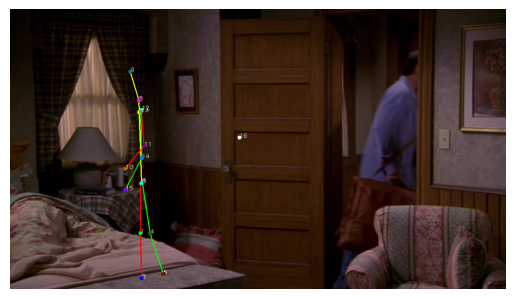

keypoints_x = " [-0.8686440677966102, -0.8516949152542372, -0.8347457627118644, -0.8771186440677966, -1.0] "
keypoints_y = " [-0.5677966101694916, -0.6101694915254237, 0.9745762711864407, 1.0, -1.0] "



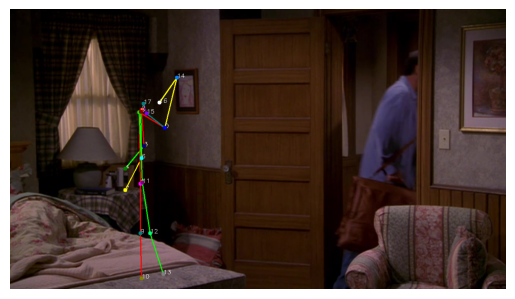

keypoints_x = " [-0.6033641822440017, -0.8602554665030896, -0.8369647109202712, -0.8136739553374528, -1.0, -0.844728296114544, -0.8369647109202712, -1.0, -0.8486100887116804, -0.8486100887116804, -0.8369647109202712, -0.8292011257259985, -0.7515652737832704, -0.6195843254806328, -0.4807006165932398, -0.7855287406051474, -0.6581529728682058, -0.8141739155501115] "
keypoints_y = " [-0.49896619328274383, -0.6575254389772425, -0.6808161945600608, -0.3198094830263758, -0.09466551239246457, -0.6614072315743789, -0.19947391251514734, 0.11883308045003727, 0.05672439889585501, 0.5497120587321778, 1.0, 0.04507902110444584, 0.5497120587321778, 0.9573002814314997, -1.0, -0.6442528842856222, -0.752329128635218, -0.7429102394665602] "



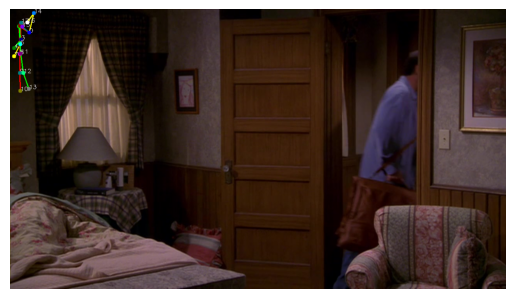

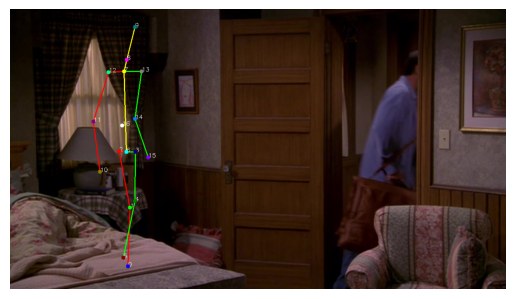

keypoints_x = " [-0.3560606060606061, -1.0, -0.4772727272727273, -0.7954545454545454, -0.5909090909090908] "
keypoints_y = " [-0.5681818181818181, -0.553030303030303, 1.0, 0.9848484848484849, -1.0] "



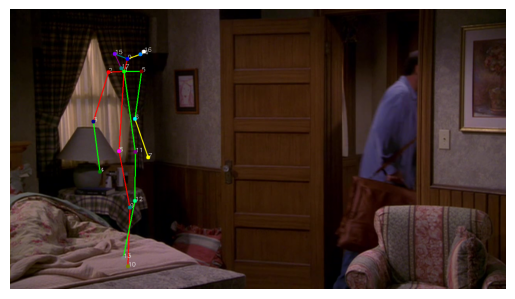

keypoints_x = " [-0.6779982661154281, -0.7134042782477072, -0.8585160360969695, -1.0, -0.9383275029140636, -0.5501535506672874, -0.6118260477532238, -0.48848105358135097, -0.7605655995487175, -0.658987369054234, -0.6771263387853919, -0.6081982538069923, -0.6118260477532238, -0.7206598661401704, -0.5586258058858209, -0.7982297505974479, -0.5283208539758086, -0.7356513637035307] "
keypoints_y = " [-0.9334806795084335, -0.817524767062008, -0.810269179169545, -0.3495393479981377, 0.11844607106573268, -0.817524767062008, -0.37493390562175866, -0.015782304944834902, -0.07382700808453968, 0.45220311411903547, 1.0, -0.06657142019207662, 0.3905306170330991, 0.9201885331829058, -0.973730543999846, -0.9805330650326983, -1.0, -0.8462787289087241] "



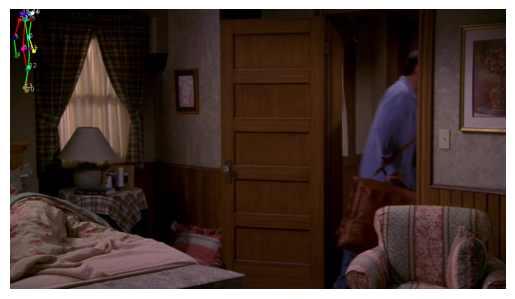

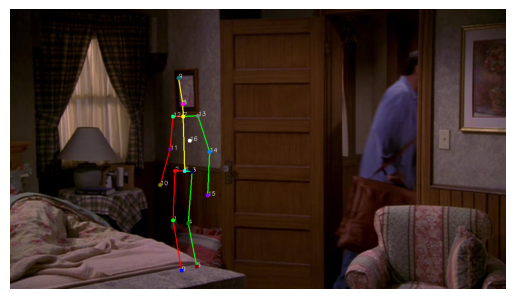

keypoints_x = " [-0.33159268929503916, -1.0, -0.48825065274151436, -0.9477806788511749, -0.7911227154046998] "
keypoints_y = " [-0.5039164490861618, -0.4830287206266318, 1.0, 0.9791122715404699, -1.0] "



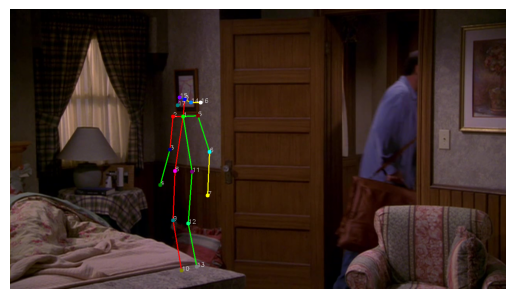

keypoints_x = " [-0.7124836336288664, -0.7342535935919356, -0.8513621794666759, -0.8873955905050575, -1.0, -0.563094891159623, -0.42796959976569193, -0.4504904816646804, -0.8288412975676873, -0.8513621794666759, -0.7522702991111264, -0.6306575368565885, -0.6756993006545655, -0.5766074202990161, -0.6419693106476425, -0.7704640517599927, -0.5312023946680617, -0.7937405654954177] "
keypoints_y = " [-0.9777176138813239, -0.7836538463998897, -0.7836538463998897, -0.40079885411708516, 0.009081196444505668, -0.7926621991594851, -0.37377379583829895, 0.13069395869904366, -0.15306915322821157, 0.4189612470060966, 1.0, -0.14406080046861613, 0.45499465804447814, 0.954958236202023, -0.9443777976603904, -1.0, -0.9430649415167602, -0.9120653211907918] "



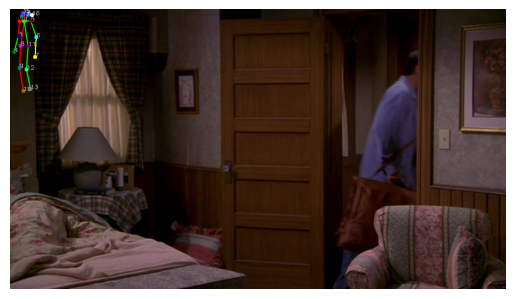

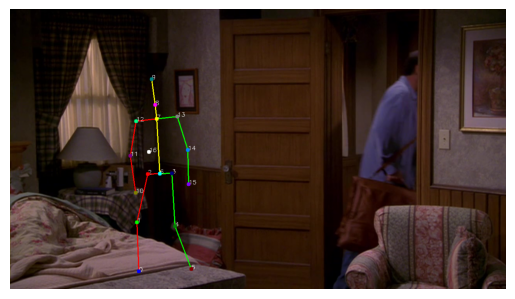

keypoints_x = " [0.09844559585492219, -1.0, -0.04663212435233166, -0.689119170984456, -0.5181347150259068] "
keypoints_y = " [-0.533678756476684, -0.40932642487046633, 0.9792746113989637, 1.0, -1.0] "



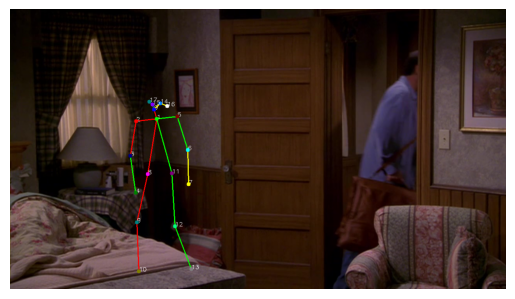

keypoints_x = " [-0.7165545555723153, -0.6877320543492508, -0.9311173649299818, -1.0, -0.9357095406013163, -0.4443467437685198, -0.320358000642487, -0.31117364929981783, -0.7933520947899454, -0.9219330135873127, -0.8989721352306399, -0.5086372031672034, -0.471899797796527, -0.2790284196004761, -0.6463609898146112, -0.7381486462897553, -0.5626314640954382, -0.7739058656558448] "
keypoints_y = " [-0.9073148525012456, -0.8001328631631426, -0.7725798091351354, -0.36387617438636055, 0.07238051439042148, -0.8276859171911499, -0.4327588094563788, -0.02864735037893862, -0.1480439178336369, 0.42138586541184697, 1.0, -0.15722826917630595, 0.4673076221251924, 0.9724469459719927, -0.98097451625703, -0.9685486561636406, -0.9497008824316143, -1.0] "



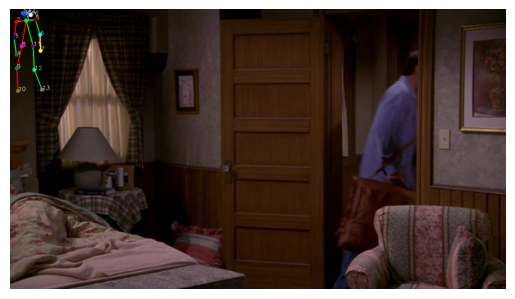

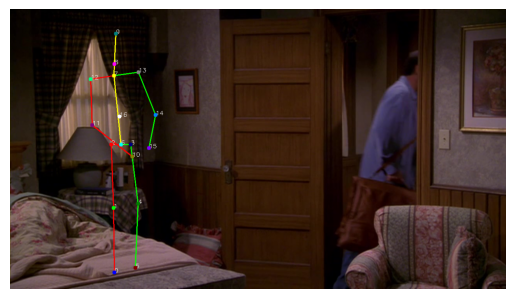

keypoints_x = " [0.06493506493506485, -1.0, -0.10822510822510822, -0.5411255411255411, -0.4588744588744589] "
keypoints_y = " [-0.6103896103896104, -0.4545454545454546, 1.0, 1.0, -1.0] "



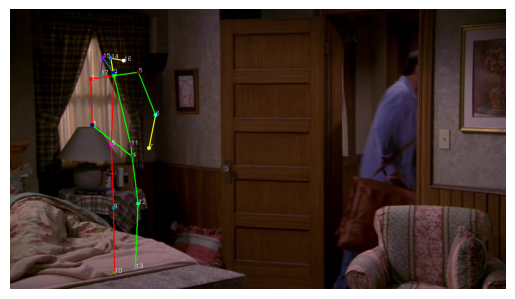

keypoints_x = " [-0.7868458142336934, -0.7828093258373712, -1.0, -0.9855206217224914, -0.6126766310766453, -0.5547591179666109, -0.39548595691401645, -0.45702331459342793, -0.8081482378230112, -0.7864291704067483, -0.779189481267994, -0.6271560093541539, -0.5583789625359881, -0.583717874521628, -0.8112031814945226, -0.8855020188801764, -0.6889940719270804, -0.9027111807234606] "
keypoints_y = " [-0.8557712399190457, -0.8316413521048364, -0.799062750980442, -0.3719210917939386, -0.07871368167438975, -0.8642199532292306, -0.4660370505977445, -0.15835026220068704, -0.1909288633250813, 0.3991058014833937, 1.0, -0.1909288633250813, 0.35928751122024494, 0.9565618651674743, -0.9940261478663854, -1.0, -0.9721756683205857, -0.8457495203922774] "



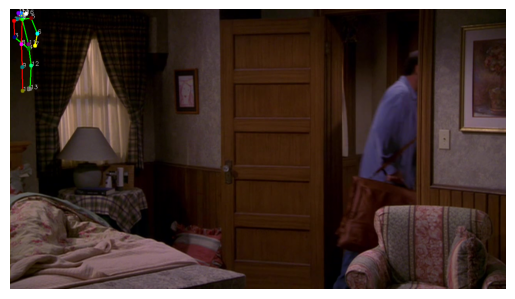

In [13]:
train_data_path = './affordance_data/trainlist.txt'
train_data = []
with open(train_data_path, 'r') as f:
    train_data = list(f.readlines())

for data in train_data[1000:]:
    vis_data(model, device, data)
    input()